In [5]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics


from sklearn.datasets import fetch_openml            # common data set access
from sklearn.preprocessing import StandardScaler     # scaling transform
from sklearn.model_selection import train_test_split # validation tools
from sklearn.metrics import accuracy_score, zero_one_loss, precision_score, recall_score, f1_score
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier, StackingClassifier
from collections import defaultdict
from sklearn.feature_selection import SelectFromModel

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid

from sklearn.preprocessing import LabelEncoder
import sklearn.tree as tree
# To use, do "conda install -c anaconda py-xgboost"
import xgboost as xgb

import pandas as pd
import time


from sklearn import svm
from sklearn.model_selection import GridSearchCV





from sklearn.impute import SimpleImputer

import warnings
warnings.filterwarnings('ignore')

# Fix the random seed for reproducibility
# !! Important !! : do not change this
seed = 1234
np.random.seed(seed)  

In [6]:
X, y = fetch_openml(data_id = 43898, return_X_y=True)






---
## Data Exploration

Explore the various aspects of the data, visualizing and analyzing it in different ways. It is really important that you are familiar with it. You should describe how you made various design choices, based on the dataset exploration.




In [3]:
print(type(X))

print(type(y))

print(X.columns)
display(X)


<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
Index(['age', 'workclass', 'fnlwgt', 'education', 'education_num',
       'marital_status', 'occupation', 'relationship', 'race', 'sex',
       'capital_gain', 'capital_loss', 'hours_per_week', 'native_country'],
      dtype='object')


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country
0,39.0,State-gov,77516.0,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States
1,50.0,Self-emp-not-inc,83311.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States
2,38.0,Private,215646.0,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States
3,53.0,Private,234721.0,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States
4,28.0,Private,338409.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48785,39.0,Private,215419.0,Bachelors,13.0,Divorced,Prof-specialty,Not-in-family,White,Female,0.0,0.0,36.0,United-States
48786,64.0,NaN,321403.0,HS-grad,9.0,Widowed,NaN,Other-relative,Black,Male,0.0,0.0,40.0,United-States
48787,38.0,Private,374983.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,50.0,United-States
48788,44.0,Private,83891.0,Bachelors,13.0,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455.0,0.0,40.0,United-States


In [4]:

allx = X.assign(income = y) #add target to dataframe to make easier plots
#display(small)
# display(allx)

small = allx.sample(n=1000) # used for testing plots faster



Text(0.5, 1.0, 'Capital Loss')

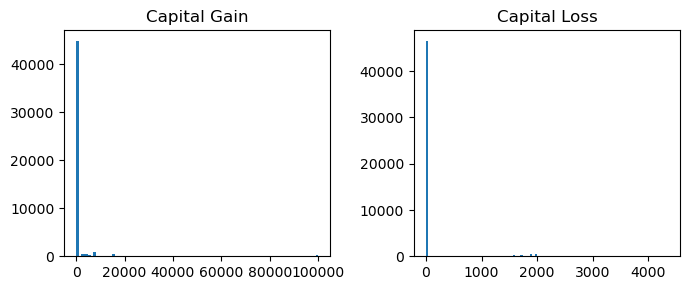

In [5]:
fig, ax = plt.subplots(1,2, tight_layout=True, figsize=(7,3))




# both of these features suck its basically all zeros
# could be an observation we write about


gain = ax[0].hist(X.capital_gain,bins=100) # 100 bins to show the amount of 0's better
ax[0].set_title("Capital Gain")
loss = ax[1].hist(X.capital_loss,bins=100)
ax[1].set_title("Capital Loss")


In [6]:
numMissing = np.count_nonzero(X.isnull())

#kind of a lot of missing data might be worth trying to fix these somehow
print("Number of rows missing Data: ", numMissing) #
print("Percentage of total data containing missing values: ", 6456/48790)


Number of rows missing Data:  6456
Percentage of total data containing missing values:  0.13232219717155155


<AxesSubplot: title={'center': 'Number of People > 50K'}>

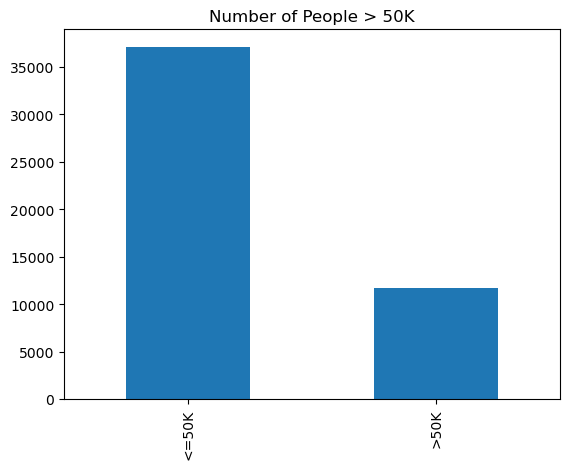

In [7]:
allx['income'].value_counts().plot(kind='bar', title='Number of People > 50K')


In [8]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
age,48790.0,38.652798,13.708493,17.0,28.0,37.0,48.00,90.0
fnlwgt,48790.0,189668.999365,105617.231232,12285.0,117555.0,178138.5,237606.25,1490400.0
education_num,48790.0,10.078807,2.570046,1.0,9.0,10.0,12.00,16.0
capital_gain,48790.0,1080.217688,7455.905921,0.0,0.0,0.0,0.00,99999.0
capital_loss,48790.0,87.595573,403.209129,0.0,0.0,0.0,0.00,4356.0
hours_per_week,48790.0,40.425886,12.392729,1.0,40.0,40.0,45.00,99.0


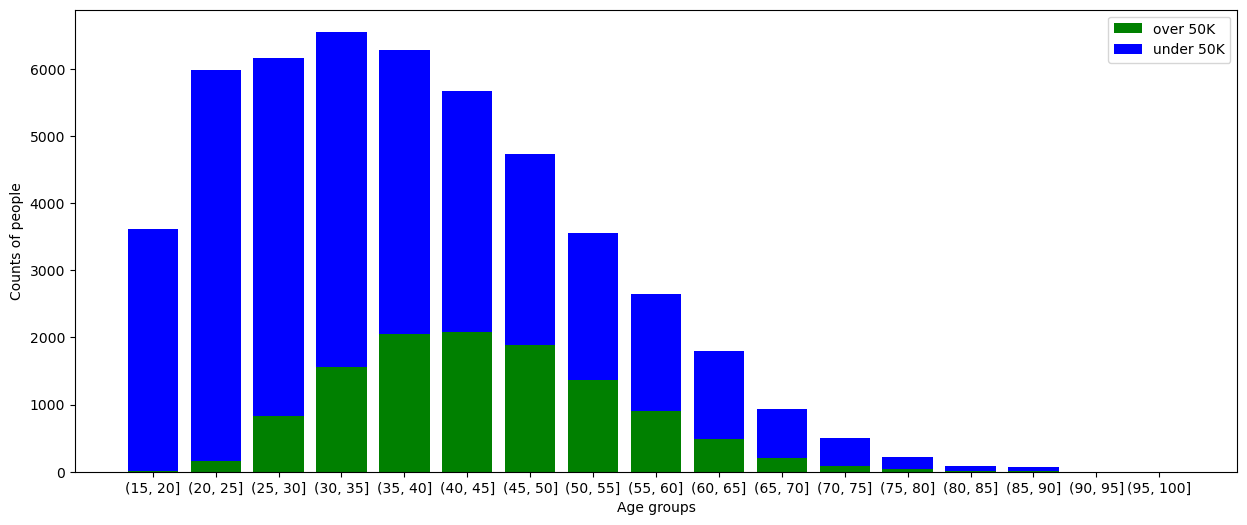

In [9]:
plt.figure(figsize=(15,6))
over = allx.loc[allx['income'] == '>50K']
under = allx.loc[allx['income'] == '<=50K']

od = pd.cut(over['age'], bins=list( range(15, 101, 5)))
ud = pd.cut(under['age'], bins=list( range(15, 101, 5)))

series = od.value_counts(sort=False)
x = series.keys().astype(str)

plt.bar(x, od.value_counts(sort=False), color='g')
plt.bar(x, ud.value_counts(sort=False), bottom=od.value_counts(sort=False), color='b')
plt.xlabel('Age groups')
plt.ylabel('Counts of people')
plt.legend(['over 50K', 'under 50K'])
plt.show()

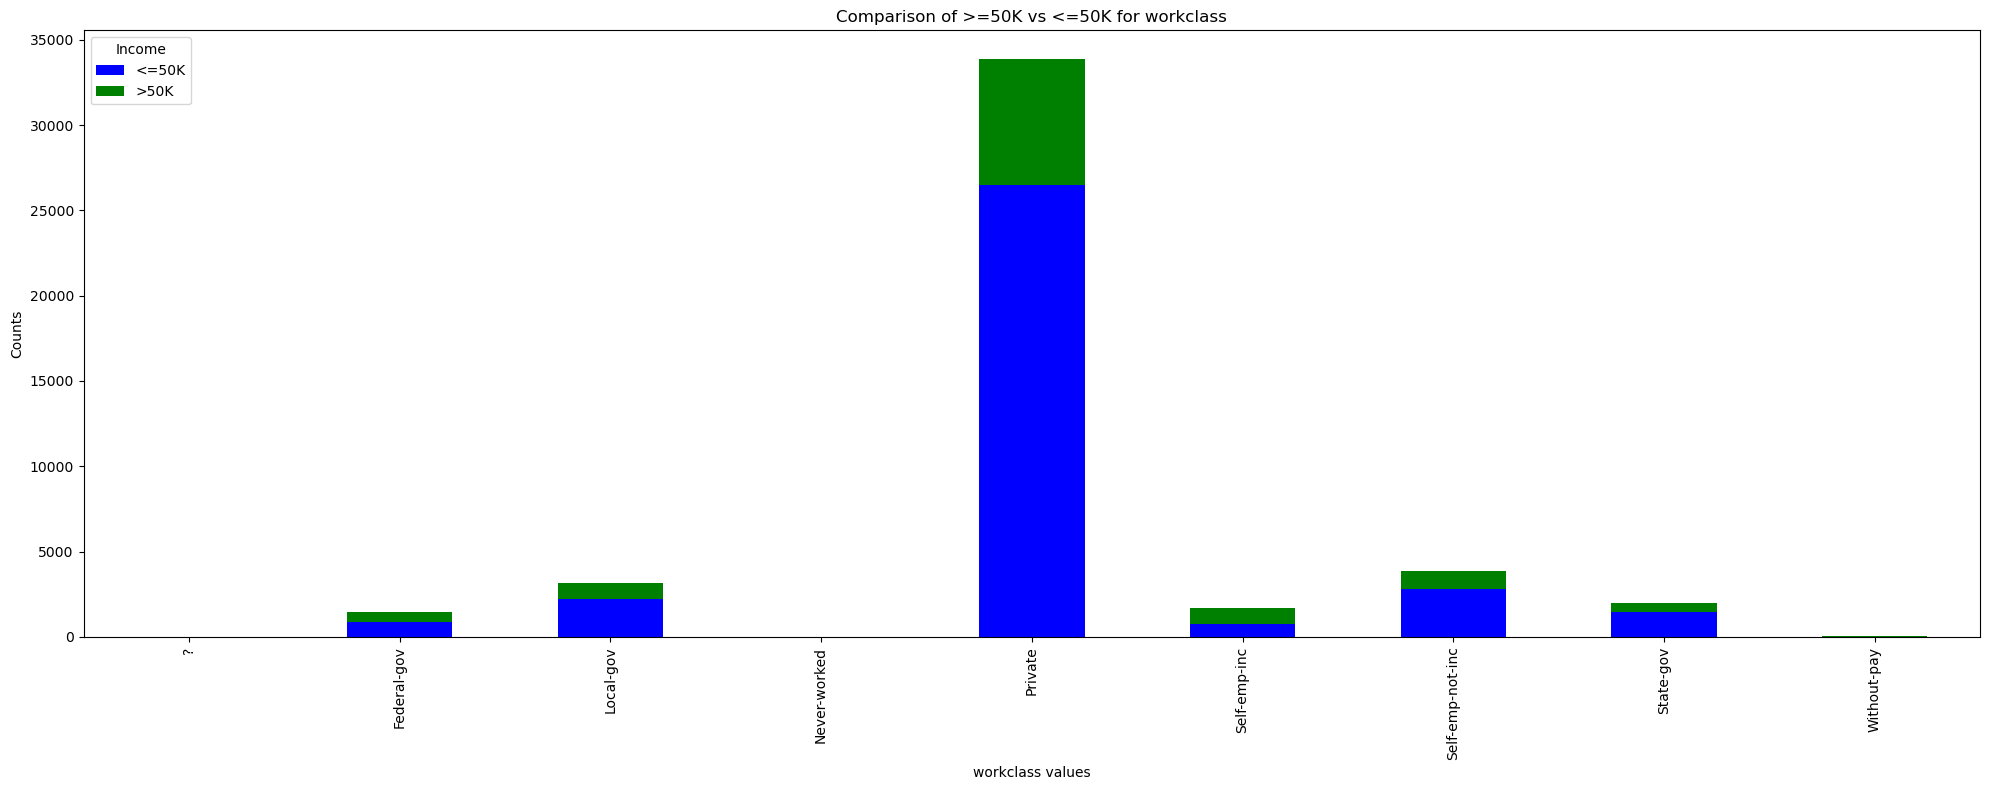

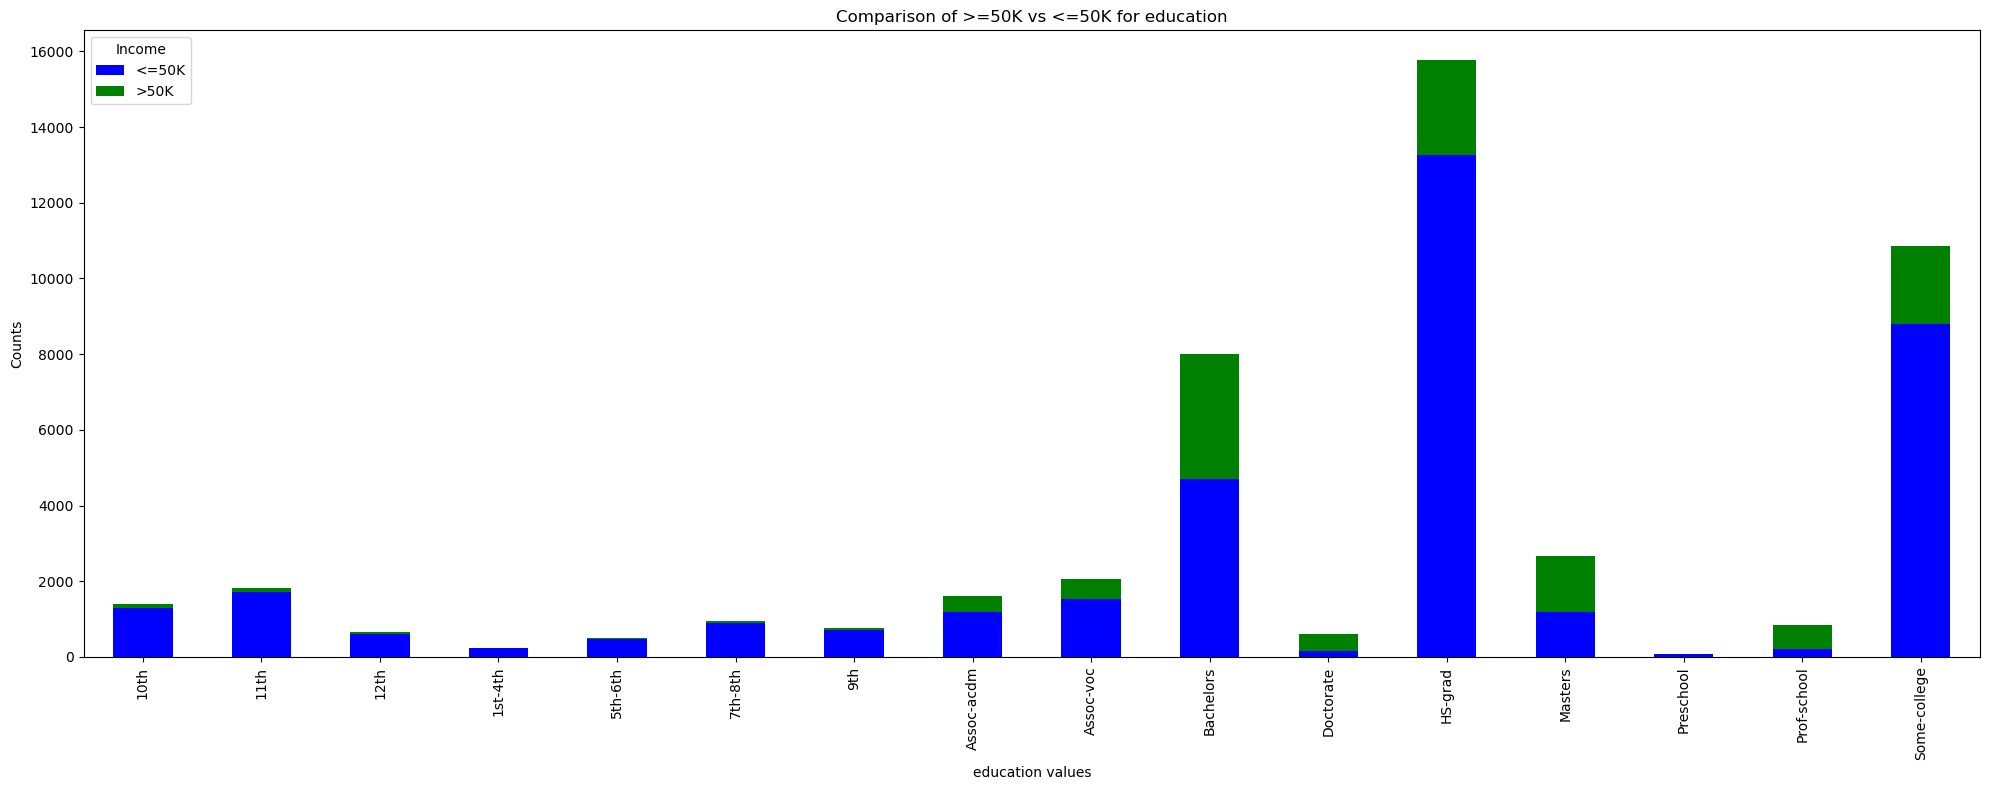

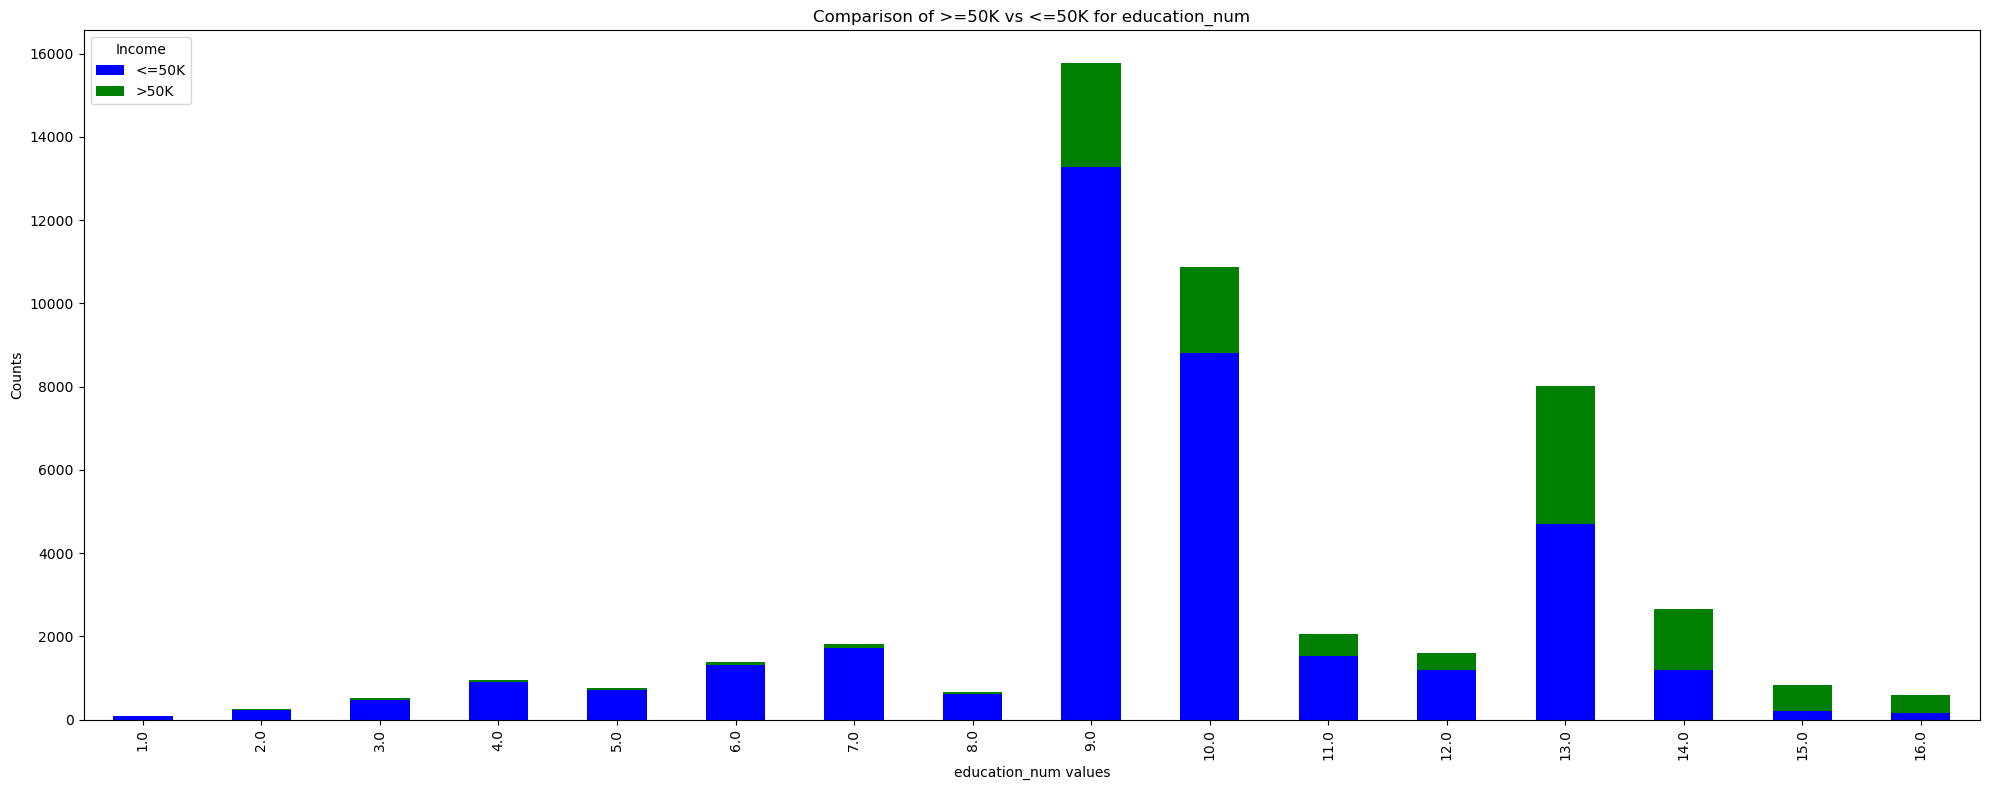

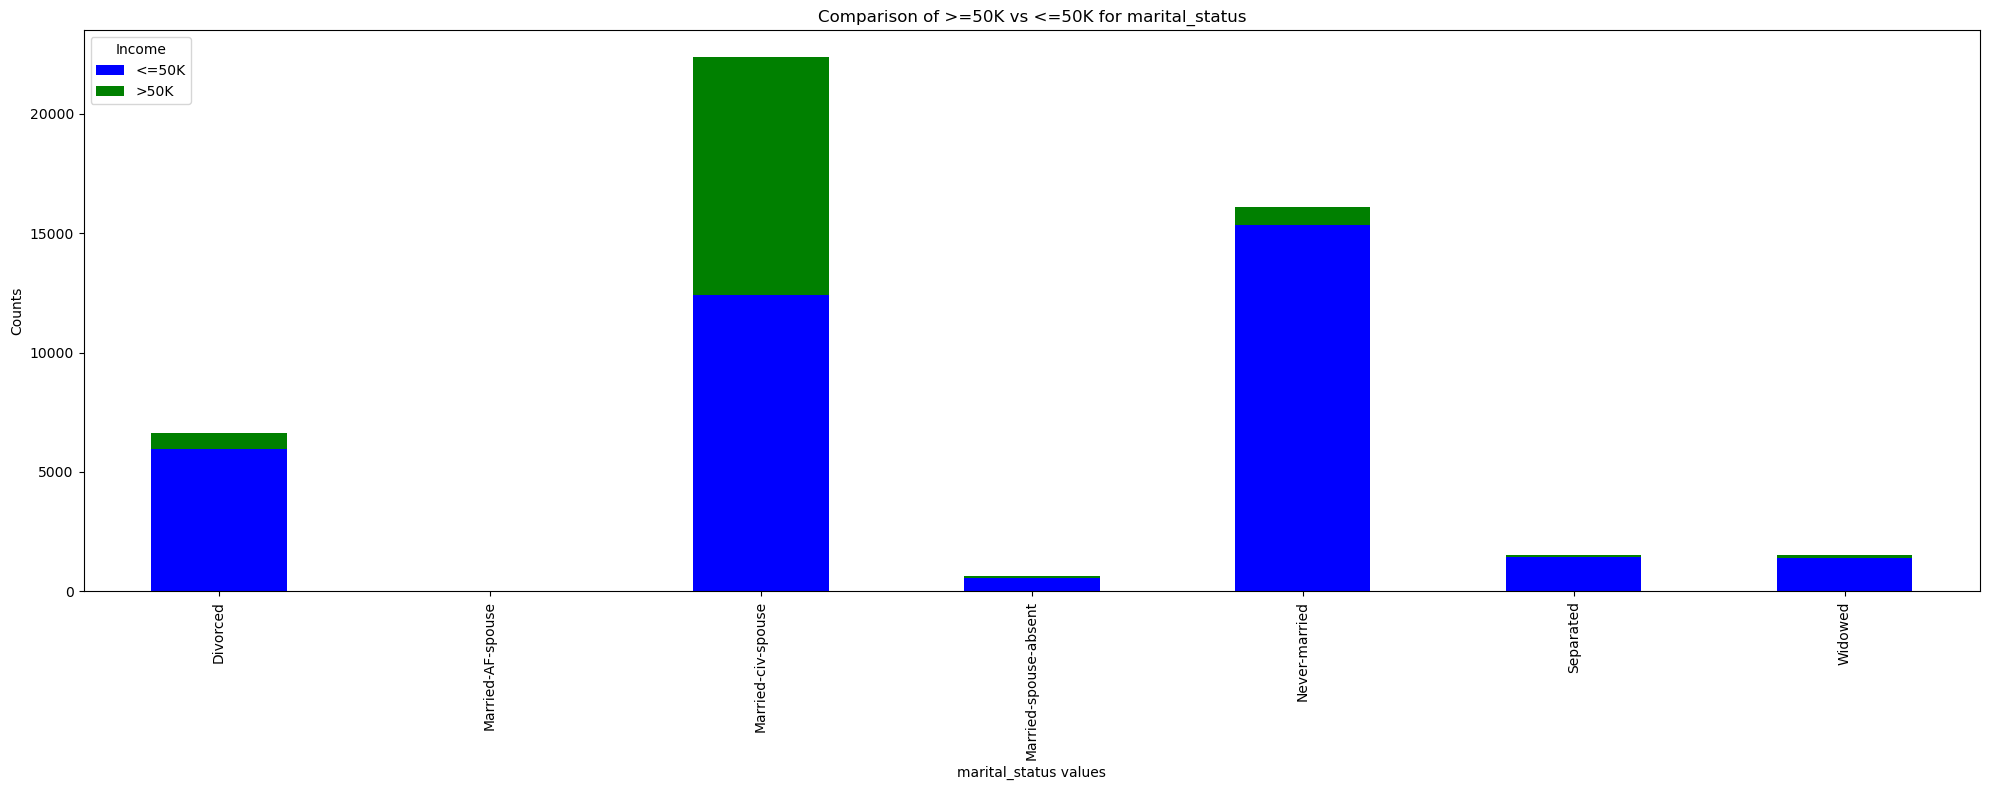

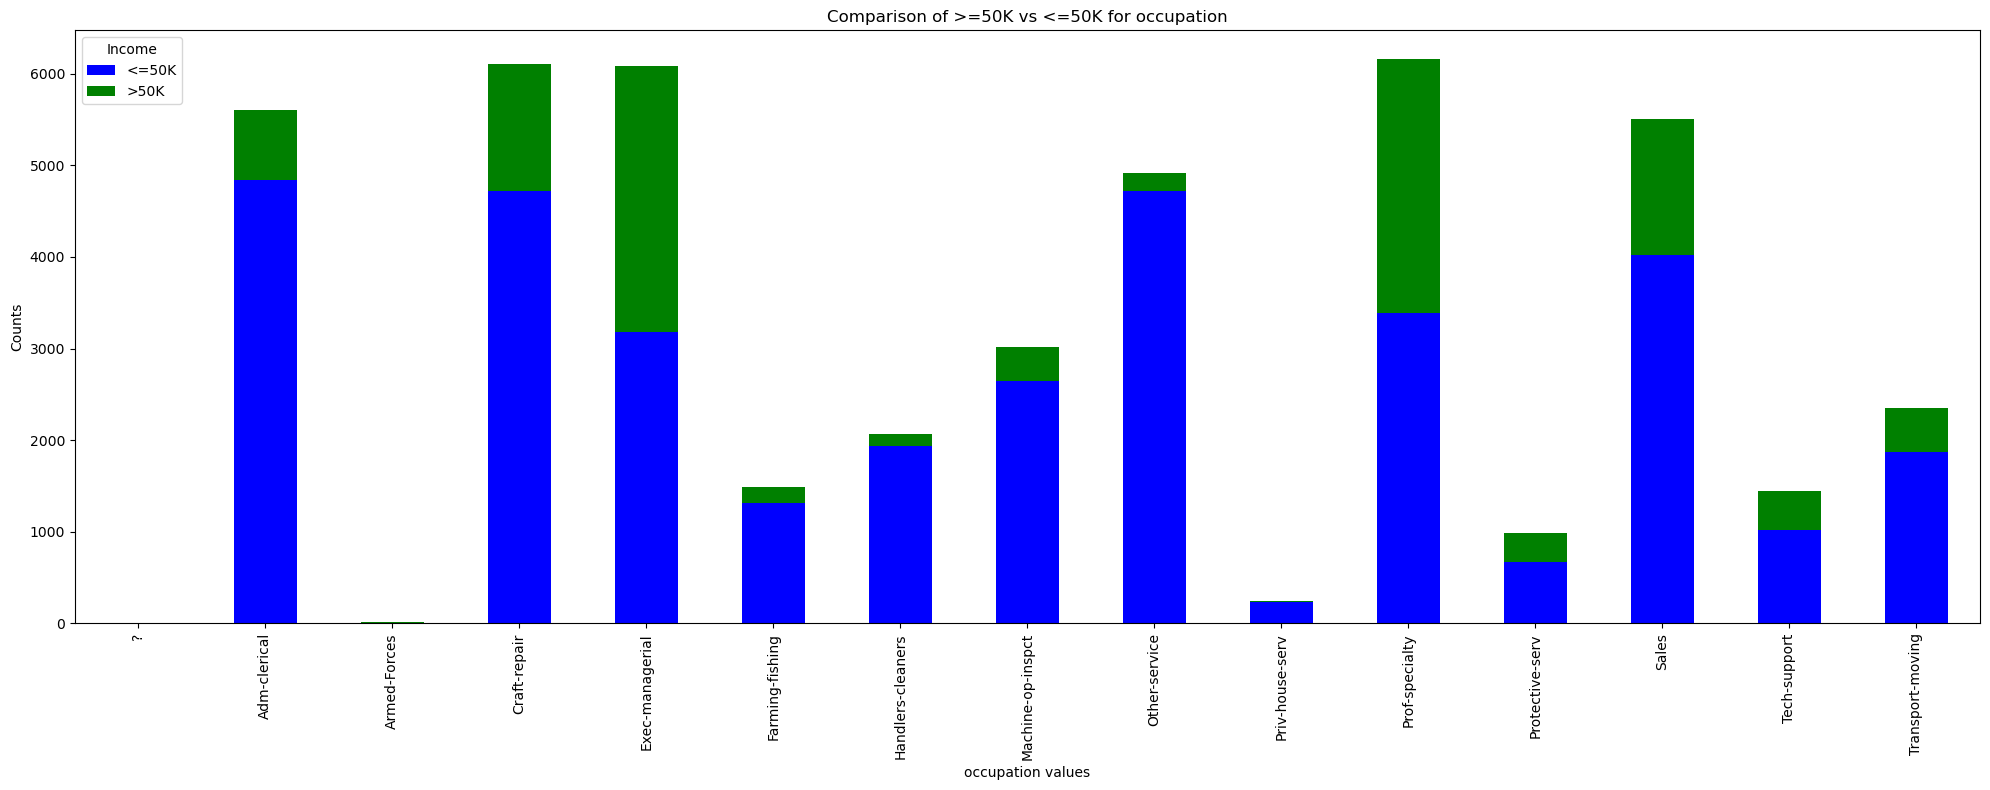

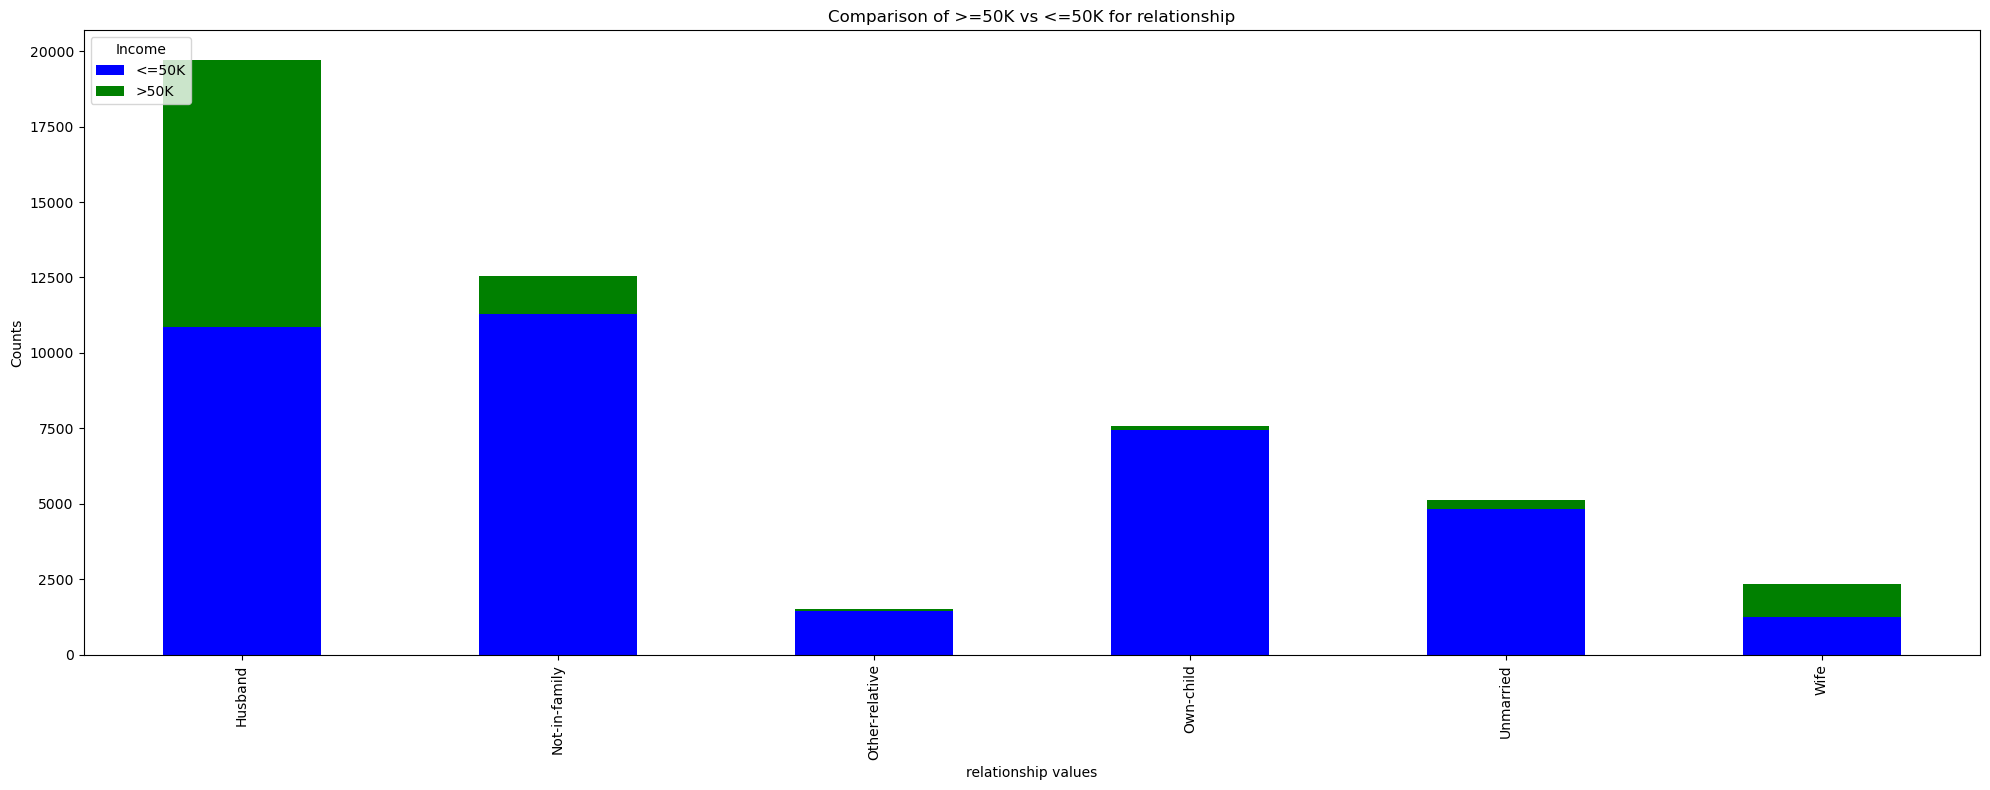

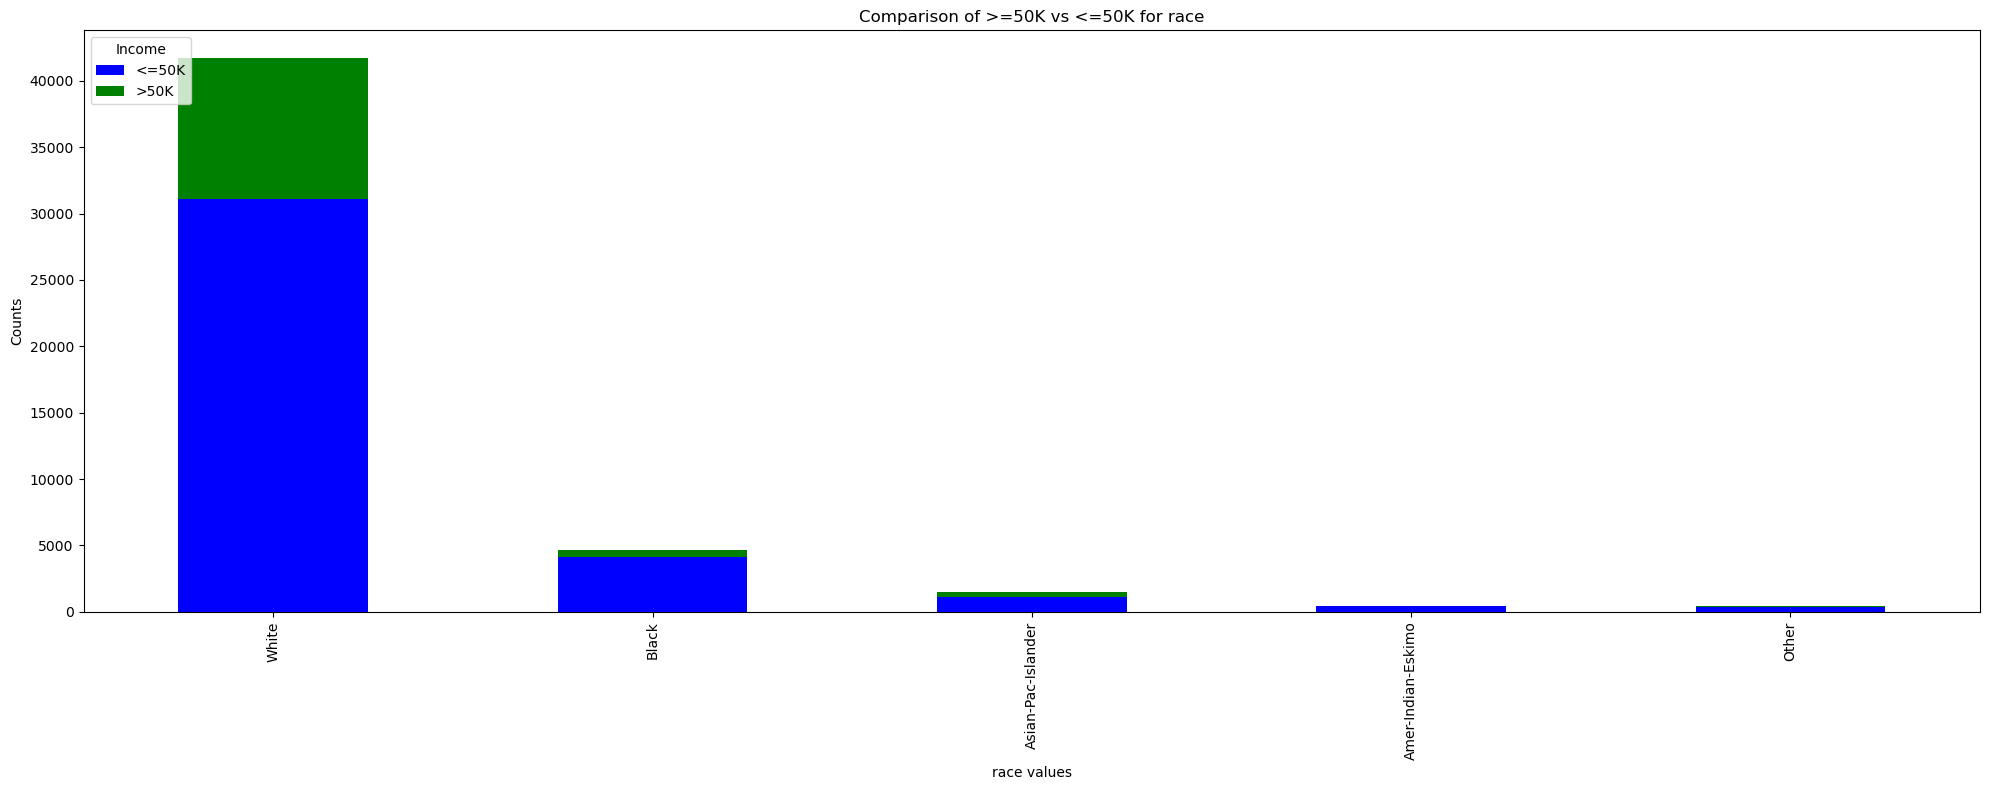

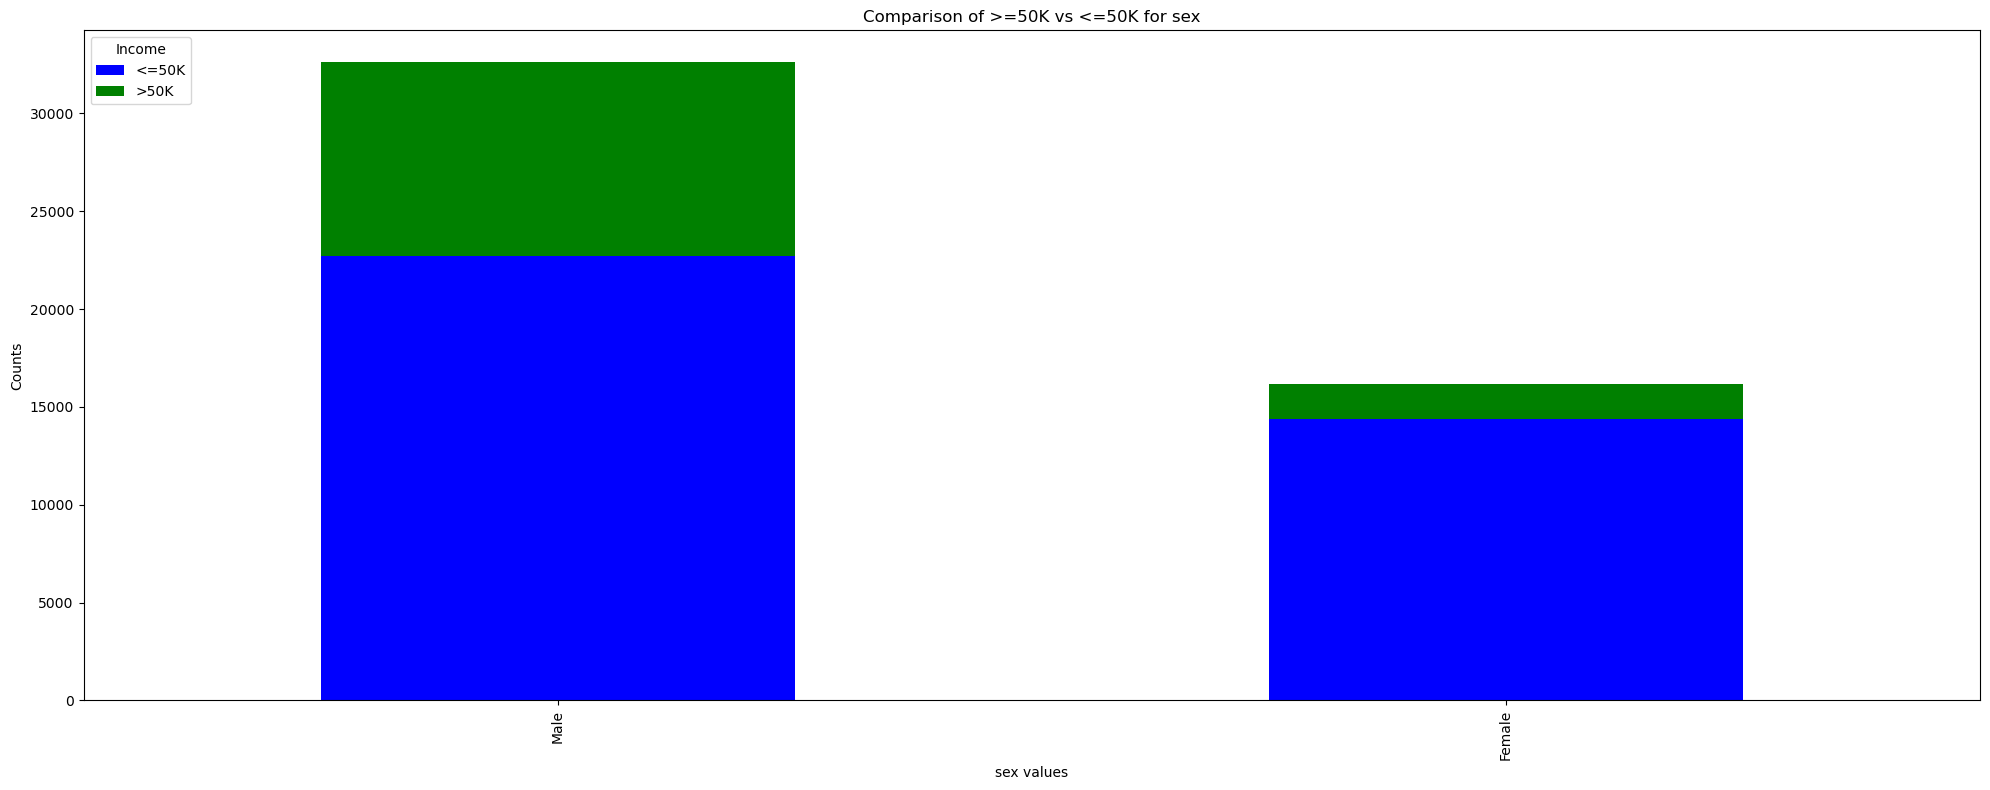

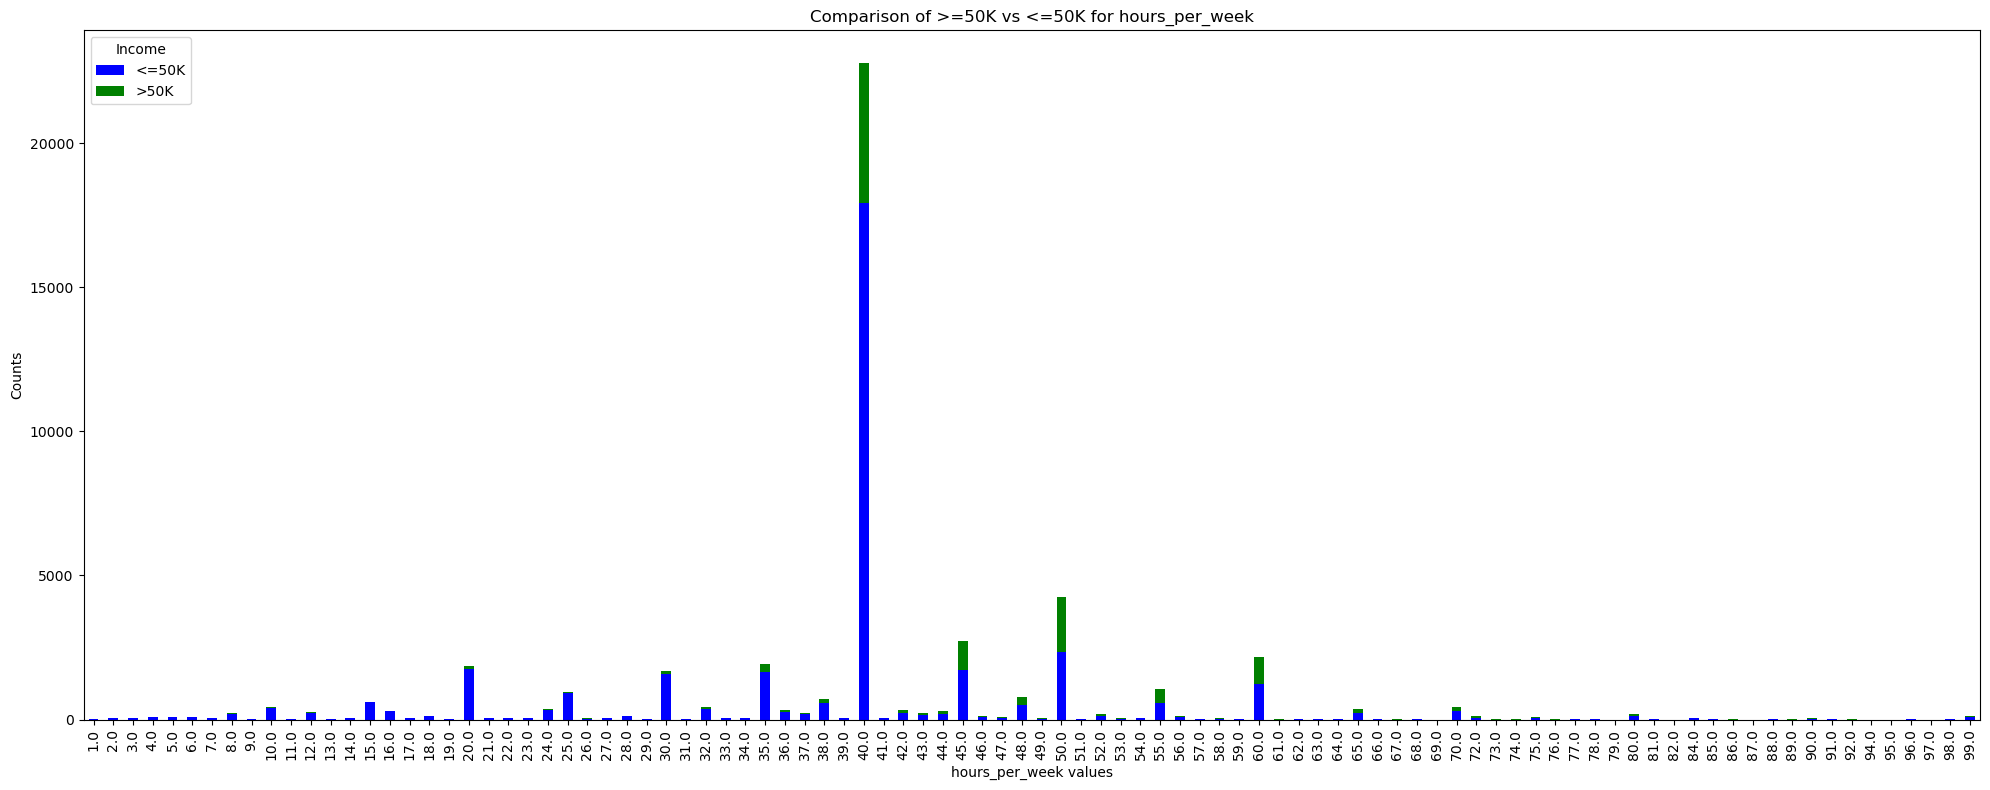

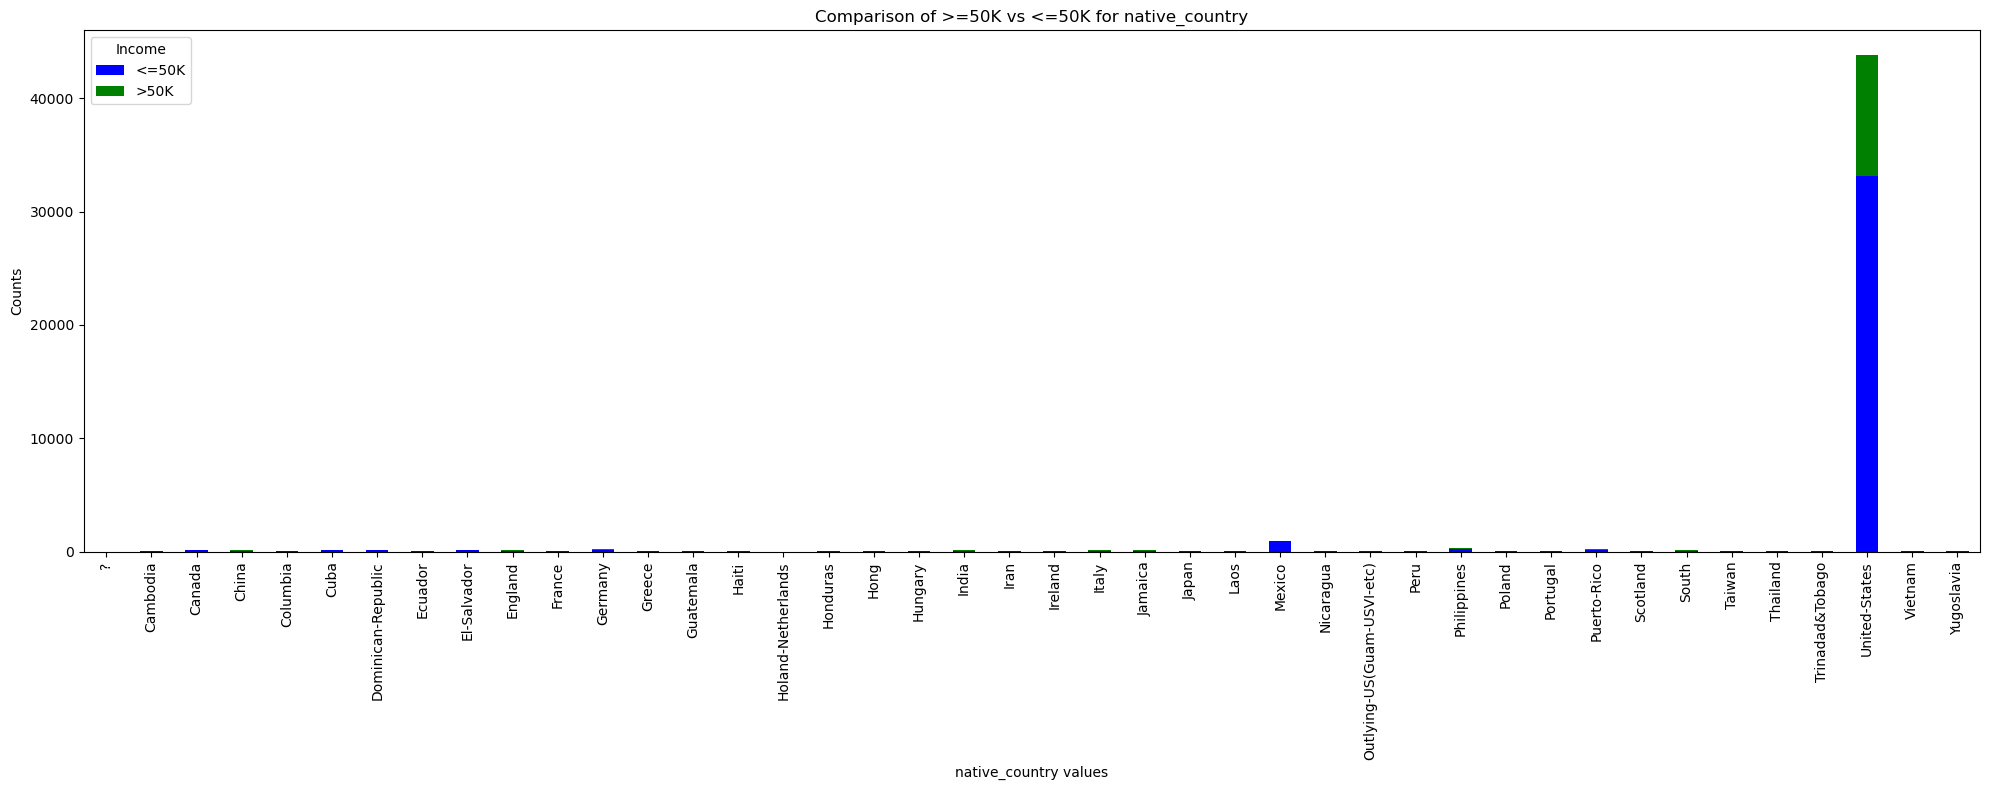

In [10]:
grouped_data = allx.groupby(['income'])
features = ['workclass', 'education', 'education_num', 'marital_status',
           'occupation', 'relationship', 'race', 'sex',
           'hours_per_week', 'native_country']
plt.rcParams["figure.figsize"] = [20,8]
for feature in features:
    counts = grouped_data[feature].value_counts().unstack().T
    counts.plot(kind='bar', stacked=True, color=['b', 'g'])
    plt.xlabel(feature + ' values')
    plt.ylabel('Counts')
    plt.title('Comparison of >=50K vs <=50K for ' + feature)
    plt.legend(title='Income', loc='upper left')
    plt.tight_layout()
    plt.show()

From the visualization, education, marital status, occupation, and relationship status seem to be correlated to whether a person earns more than 50k

<AxesSubplot: title={'center': 'race'}>

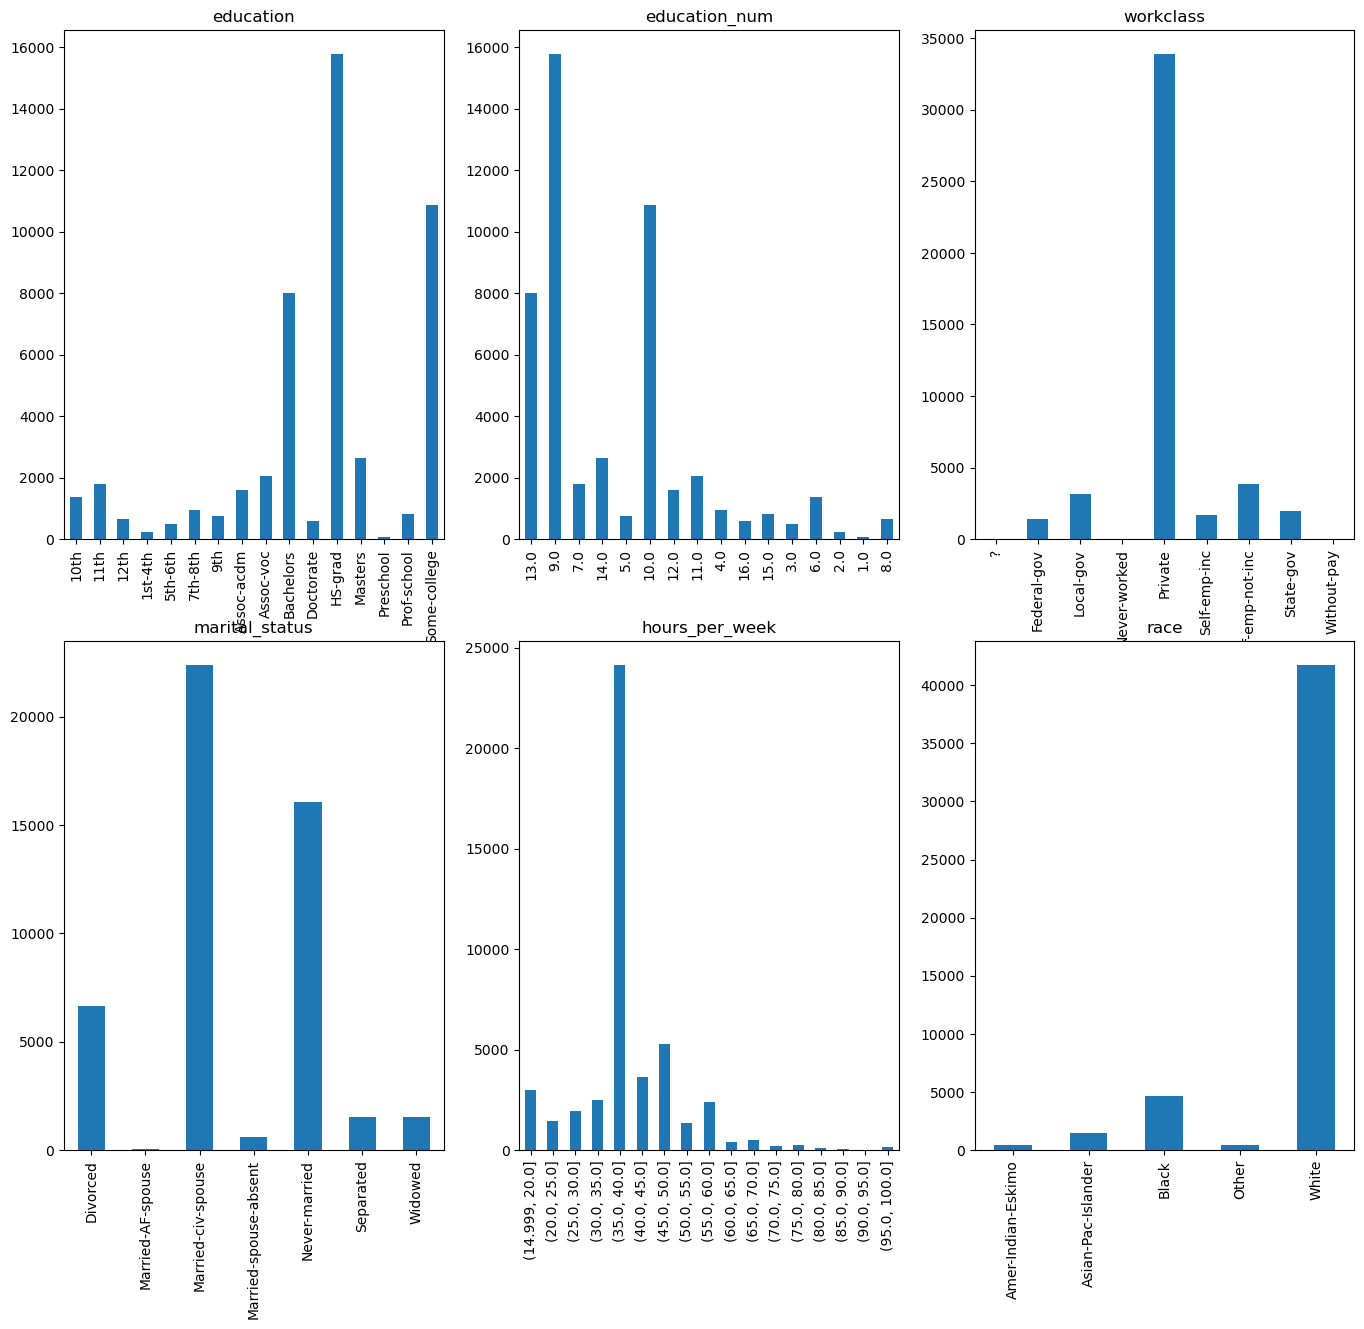

In [11]:
plt.rcParams["figure.figsize"] = [12,8]
plt.subplots_adjust(bottom=0.1, right=1.2, top=1.5)

plt.subplot(2,3,1)
allx['education'].value_counts(sort=False).plot(kind='bar', title='education')

plt.subplot(2,3,2)
allx['education_num'].value_counts(sort=False).plot(kind='bar', title='education_num')

plt.subplot(2,3,3)
allx['workclass'].value_counts(sort=False).plot(kind='bar', title='workclass')

plt.subplot(2,3,4)
allx['marital_status'].value_counts(sort=False).plot(kind='bar', title='marital_status')

plt.subplot(2,3,5)
divided_w = pd.cut(allx['hours_per_week'], bins=list( range(15, 101, 5) ), include_lowest=True)
divided_w.value_counts(sort=False).plot(kind='bar', title='hours_per_week')

plt.subplot(2,3,6)
allx['race'].value_counts(sort=False).plot(kind='bar', title='race')

___
## Preprocessing

In [7]:
le = LabelEncoder()
# This not only handles categorical variables and turns them into integers, 
# it also handles NaN values by turning them into another label
# need to be careful thoguh since it might cause problems with interpreting higher value 
# numbers as better when that might not be the case.
# Ex: Cuba > Italy simply becuase the label number is higher


#Simplified label encoder
cat_cols = [col for col in X.columns if X[col].dtype == 'object' or pd.api.types.is_categorical_dtype(X[col])]

X[cat_cols] = X[cat_cols].apply(lambda col: le.fit_transform(col))

y= le.fit_transform(y)


display(X)
display(y)

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country
0,39.0,6,77516.0,9,13.0,4,0,1,4,1,2174.0,0.0,40.0,38
1,50.0,5,83311.0,9,13.0,2,3,0,4,1,0.0,0.0,13.0,38
2,38.0,3,215646.0,11,9.0,0,5,1,4,1,0.0,0.0,40.0,38
3,53.0,3,234721.0,1,7.0,2,5,0,2,1,0.0,0.0,40.0,38
4,28.0,3,338409.0,9,13.0,2,9,5,2,0,0.0,0.0,40.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48785,39.0,3,215419.0,9,13.0,0,9,1,4,0,0.0,0.0,36.0,38
48786,64.0,8,321403.0,11,9.0,6,14,2,2,1,0.0,0.0,40.0,38
48787,38.0,3,374983.0,9,13.0,2,9,0,4,1,0.0,0.0,50.0,38
48788,44.0,3,83891.0,9,13.0,0,0,3,1,1,5455.0,0.0,40.0,38


array([0, 0, 0, ..., 0, 0, 1])

___
## Model exploration
Exploration of at least one or two techniques on which we did not spend significant time in class. For example, using neural networks, support vector machines, or random forests are great ideas; but if you do this, you should explore in some depth the various options available to you for parameterize the model, controlling complexity, etc. (This should involve more than simply varying a parameter and showing a plot of results.)

In [8]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=seed, shuffle=True)

X_tr_unscaled = X_tr.copy()
X_te_unscaled = X_te.copy()

scaler = StandardScaler()
scaler.fit(X_tr)
X_tr = scaler.transform(X_tr)     
X_te = scaler.transform(X_te)     

In [13]:
#Testing that dataset seems to be working properly
#This is where we start with new models/exploring different parameters

learner = LogisticRegression()
learner.fit(X_tr,y_tr);
tr_y = learner.predict(X_tr)
te_y =  learner.predict(X_te)
print(tr_y)
err1 = accuracy_score(y_tr, tr_y)
err2 = accuracy_score(te_y, y_te)
print(1-err1)
print(1-err2)

[0 0 0 ... 0 0 0]
0.17565074810411974
0.1697069071531051


In [14]:
sklearn_nearest_centroid = NearestCentroid()

# Fit on training dataset
sklearn_nearest_centroid.fit(X_tr, y_tr)

# Make predictions on training and testing data
sklearn_y_pred_tr = sklearn_nearest_centroid.predict(X_tr)
sklearn_y_pred_te = sklearn_nearest_centroid.predict(X_te)

# Evaluate accuracies using the sklearn function accuracy_score
acc_tr = accuracy_score(y_tr, sklearn_y_pred_tr)
acc_te = accuracy_score(y_te, sklearn_y_pred_te)
print(1-acc_tr)
print(1-acc_te)

0.2631686821069892
0.2596843615494978


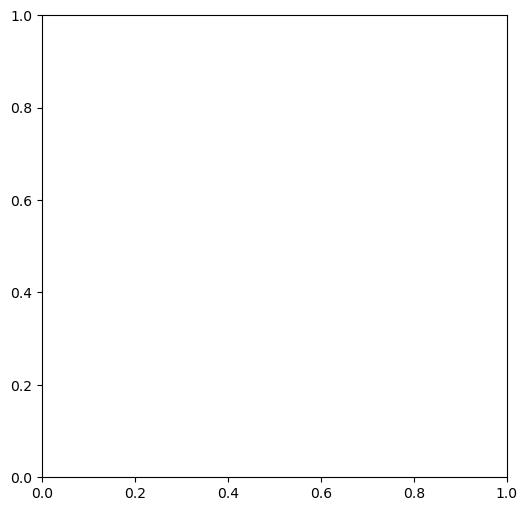

In [11]:

errors = []

k_vals = [35, 38, 40, 42, 45]
k_valsDF = pd.DataFrame(columns=['k','Training Error', 'Testing Error'])
for i, k in enumerate(k_vals):
    knn = KNeighborsClassifier(n_neighbors=k)   # TODO
    knn.fit(X_tr,y_tr) # TODO 
    
    sklearn_y_pred_tr = knn.predict(X_tr)
    sklearn_y_pred_te = knn.predict(X_te)
    
    sklearn_acc_tr = accuracy_score(y_tr, sklearn_y_pred_tr)
    sklearn_acc_te = accuracy_score(y_te, sklearn_y_pred_te)
    errors.append([1- sklearn_acc_tr, 1- sklearn_acc_te])
    
    k_valsDF.loc[len(k_valsDF)] = [k,1- sklearn_acc_tr, 1- sklearn_acc_te]


In [12]:
# Displays formatted table of parameter tests with testing and training
# Tested first and noticed best testing error was between 25 and 50 so i narrowed the search between those
display(k_valsDF)

,k,Training Error,Testing Error
0,35.0,0.152106,0.159971
1,38.0,0.152516,0.161509
2,40.0,0.152516,0.161201
3,42.0,0.153618,0.159971
4,45.0,0.154617,0.161509


In [17]:
parameters = {'kernel':('linear', 'poly', 'rbf', 'sigmoid'), 'C': [1,2,5,25]}
#parameters = {'kernel':('linear', 'rbf'), 'C': [0.1, 1]}

grid = GridSearchCV(svm.SVC(), parameters, refit = True, verbose = 3,n_jobs=-1) 
   


In [18]:
grid.fit(X_tr, y_tr) # RUNNING THIS TAKES A VERY LONG TIME AND IS VERY CPU INTENSIVE DONT RE RUN UNLESS NECESSARY
                     # the grid variable already stores the results from running this I put it in its own cell to prevent this

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': [1, 2, 5, 25],
                         'kernel': ('linear', 'poly', 'rbf', 'sigmoid')},
             verbose=3)

In [19]:
display(pd.DataFrame(grid.cv_results_))
print("Lowest testing error:\n", 1- grid.best_score_)
print("Best parameters",grid.best_params_)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,43.641384,2.015702,4.034183,0.158506,1,linear,"{'C': 1, 'kernel': 'linear'}",0.812604,0.814525,0.815911,0.814117,0.806047,0.812641,0.003461,10
1,34.287059,2.014448,4.149051,0.481415,1,poly,"{'C': 1, 'kernel': 'poly'}",0.837454,0.849622,0.843710,0.843454,0.845888,0.844025,0.003960,8
2,29.074658,0.495728,12.692808,0.546139,1,rbf,"{'C': 1, 'kernel': 'rbf'}",0.844370,0.850775,0.853702,0.847169,0.853702,0.849944,0.003680,1
3,26.731858,2.329927,3.306956,0.142986,1,sigmoid,"{'C': 1, 'kernel': 'sigmoid'}",0.748943,0.754451,0.751473,0.758263,0.753523,0.753331,0.003109,14
4,58.130880,2.889303,4.354062,0.700849,2,linear,"{'C': 2, 'kernel': 'linear'}",0.812604,0.814525,0.815911,0.814117,0.806047,0.812641,0.003461,10
5,37.780905,1.082095,3.951527,0.215819,2,poly,"{'C': 2, 'kernel': 'poly'}",0.838606,0.849494,0.846016,0.843198,0.847297,0.844922,0.003758,6
6,30.957445,2.091072,13.082404,0.789156,2,rbf,"{'C': 2, 'kernel': 'rbf'}",0.844627,0.851159,0.853062,0.847809,0.852421,0.849816,0.003165,2
7,27.169929,5.248035,3.323355,0.311294,2,sigmoid,"{'C': 2, 'kernel': 'sigmoid'}",0.748047,0.753170,0.750192,0.757110,0.754035,0.752511,0.003137,15
8,100.993583,4.370675,4.318563,0.576859,5,linear,"{'C': 5, 'kernel': 'linear'}",0.812604,0.814525,0.815911,0.814117,0.806047,0.812641,0.003461,10
9,57.972326,4.707230,4.209357,0.640402,5,poly,"{'C': 5, 'kernel': 'poly'}",0.838991,0.848597,0.846656,0.843710,0.848194,0.845230,0.003561,5


Lowest testing error:
 0.15005624251556104
Best parameters {'C': 1, 'kernel': 'rbf'}


In [20]:
clf = svm.SVC(kernel='rbf', C=1)

clf.fit(X_tr, y_tr)
tre = 1 - accuracy_score(y_tr, clf.predict(X_tr))
tee = 1 - accuracy_score(y_te, clf.predict(X_te))
print(tre,tee)






0.1433183029309285 0.15136298421807748


In [21]:
# Decision Trees
# simple decision tree as a baseline
# there are still room for improvement based on the validation error
# hope to see some improvements using random forest or adaboost
dt_base = tree.DecisionTreeClassifier(criterion='entropy',
                                 max_depth=100,
                                 random_state=seed)
dt_base.fit(X_tr_unscaled, y_tr)
dt_tr_pred = dt_base.predict(X_tr_unscaled)
print(f'Training error: {(y_tr != dt_base.predict(X_tr_unscaled)).mean()}')
print(f'Validation error: {(y_te != dt_base.predict(X_te_unscaled)).mean()}')

Training error: 7.686001229760196e-05
Validation error: 0.18774339003894241


In [14]:
#Check what features could be removed from the dataset

rf = RandomForestClassifier(n_estimators = 100, 
                            max_depth=100,
                            random_state = seed)

thresholdValue = ['mean','median','0.25*median','1.25*median']
for thresh in thresholdValue:
    sfm = SelectFromModel(rf, threshold = thresh)
    sfm.fit(X_tr_unscaled,y_tr)

    selected_features = X_tr_unscaled.columns[sfm.get_support()]
    print(selected_features)
    rf.fit(X_tr_unscaled[selected_features],y_tr)

    accuracyTr = accuracy_score(y_tr,rf.predict(X_tr_unscaled[selected_features]))
    accuracyTe = accuracy_score(y_te,rf.predict(X_te_unscaled[selected_features]))
    print(f'Threshold Type: {thresh}')
    print(f'Training accuracy: {accuracyTr}')
    print(f'Testing accuracy: {accuracyTe}\n')


Index(['age', 'fnlwgt', 'education_num', 'relationship', 'capital_gain',
       'hours_per_week'],
      dtype='object')
Threshold Type: mean
Training accuracy: 0.9990264398442303
Testing accuracy: 0.8287558926009428

Index(['age', 'fnlwgt', 'education_num', 'marital_status', 'relationship',
       'capital_gain', 'hours_per_week'],
      dtype='object')
Threshold Type: median
Training accuracy: 0.9990776798524288
Testing accuracy: 0.830190612830498

Index(['age', 'workclass', 'fnlwgt', 'education', 'education_num',
       'marital_status', 'occupation', 'relationship', 'capital_gain',
       'capital_loss', 'hours_per_week', 'native_country'],
      dtype='object')
Threshold Type: 0.25*median
Training accuracy: 0.999871899979504
Testing accuracy: 0.8574502971920476

Index(['age', 'fnlwgt', 'education_num', 'relationship', 'capital_gain'], dtype='object')
Threshold Type: 1.25*median
Training accuracy: 0.9963875794220127
Testing accuracy: 0.8168682106989137



0.25 * median seems to be the best threshold, as the other options are removing too many features to predict

Training accuracy: 0.8542990366878459
Testing accuracy: 0.8541709366673499
Precision: 0.790506329113924
Recall: 0.5335326783425887
F1 score: 0.637082376944657


Training accuracy: 0.8732322197171551
Testing accuracy: 0.8610370977659356
Precision: 0.7686852154937261
Recall: 0.6018795386586928
F1 score: 0.6751317680881648


Training accuracy: 0.9184771469563435
Testing accuracy: 0.8612420577987292
Precision: 0.751145038167939
Recall: 0.6304997864160615
F1 score: 0.6855550394797957


Training accuracy: 0.9184771469563435
Testing accuracy: 0.8612420577987292
Precision: 0.751145038167939
Recall: 0.6304997864160615
F1 score: 0.6855550394797957


Training accuracy: 0.9184771469563435
Testing accuracy: 0.8612420577987292
Precision: 0.751145038167939
Recall: 0.6304997864160615
F1 score: 0.6855550394797957


Training accuracy: 0.9319276491084239
Testing accuracy: 0.859807337569174
Precision: 0.7496151872755259
Recall: 0.6240922682614267
F1 score: 0.6811188811188811


Training accuracy: 0.9585980

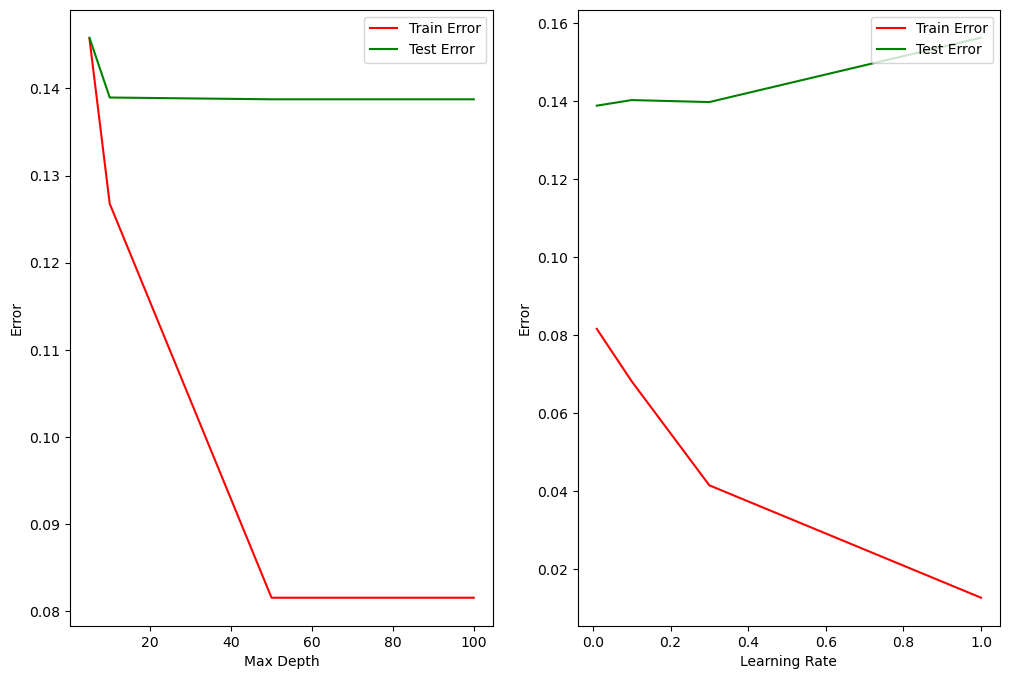

In [15]:
#Test XGBoost for decision tree
fig,ax = plt.subplots(1,2,figsize=(12,8))

#Create the matrix and parameters for training the model
maxDepth = [5,10,50,100]
learningRate = [0.01,0.1,0.3,1.0]

bestDepth = maxDepth[0]
bestLR = learningRate[0]

maxAcc = 0

dtrain = xgb.DMatrix(data = X_tr_unscaled, label = y_tr)

for ind,i in enumerate([maxDepth,learningRate]):
    accuracyTe = []
    accuracyTr = []
    for j in i:
        if i == maxDepth:
            curDepth = j
            curLR = bestLR
        else:
            curDepth = bestDepth
            curLR = j
        params = {
            'max_depth':curDepth,
            'objective':'binary:logistic',
            'eval_metric':'logloss',
            'subsample':0.8,
            'colsample_bytree':0.8,
            'learning_rate': curLR,
            'random_state':seed
        }

        model = xgb.train(params = params,dtrain = dtrain,)

        #Prediction
        y_pred = model.predict(xgb.DMatrix(data=X_te_unscaled))
        y_train_pred = model.predict(xgb.DMatrix(data = X_tr_unscaled))
        y_pred_binary = [1 if p > 0.5 else  0 for p in y_pred]
        y_train_pred_binary = [1 if p>0.5 else 0 for p in y_train_pred]

        #Check its accuracy 
        accuracyTe.append(accuracy_score(y_pred_binary,y_te))
        accuracyTr.append(accuracy_score(y_train_pred_binary,y_tr))
        print(f'Training accuracy: {accuracyTr[-1]}')
        print(f'Testing accuracy: {accuracyTe[-1]}')
        #Precision: True positive prediction / Total positive prediction
        print("Precision:", precision_score(y_te, y_pred_binary))
        #Recall: True positive prediction / Total positive result
        print("Recall:", recall_score(y_te, y_pred_binary))
        #F1 Score: Combine both Precision and Recall
        print("F1 score:", f1_score(y_te, y_pred_binary))
        print('\n')
        if maxAcc < accuracyTe[-1]:
            maxAcc = accuracyTe[-1]
            if i == maxDepth:
                bestDepth = j
            else:
                    bestLR = j
    if ind == 0:
        ax[ind].plot(maxDepth,[1-x for x in accuracyTr],'red', label = "Train Error")
        ax[ind].plot(maxDepth,[1-x for x in accuracyTe],'green', label = "Test Error")
        ax[ind].set_xlabel('Max Depth')
        ax[ind].set_ylabel('Error')
        ax[ind].legend(loc='upper right')
    else:
        ax[ind].plot(learningRate,[1-x for x in accuracyTr],'red', label = "Train Error")
        ax[ind].plot(learningRate,[1-x for x in accuracyTe],'green', label = "Test Error")    
        ax[ind].set_xlabel('Learning Rate')
        ax[ind].set_ylabel('Error')
        ax[ind].legend(loc='upper right')

print(f'Best Depth: {bestDepth}')
print(f'Best Learning Rate: {bestLR}')
print(f'Highest Accuracy: {maxAcc}')
# Since it has high precision score => Most of its positive predictions are correct.
# However, the number of positive prediction is only about half of what is expected


In [24]:
#Use data augmentation to improve model
# Use 3 random forests: the prediction from the first 2 forests are added as feature for the dataset
# Use the third random forest to train on the new dataset and predict
rf1 = RandomForestClassifier(n_estimators = 100, 
                            max_depth=100,
                            random_state = seed)
rf1.fit(X_tr_unscaled, y_tr)
y_pred_1 = rf1.predict(X_tr_unscaled)
y_te_pred_1 = rf1.predict(X_te_unscaled)

rf2 = RandomForestClassifier(n_estimators = 100, 
                            max_depth=100,
                            random_state = seed+1)
rf2.fit(X_tr_unscaled, y_tr)
y_pred_2 = rf2.predict(X_tr_unscaled)
y_te_pred_2 = rf2.predict(X_te_unscaled)

X_tr_new = np.column_stack((X_tr_unscaled,y_pred_1,y_pred_2))
X_te_new = np.column_stack((X_te_unscaled,y_te_pred_1,y_te_pred_2))

rf3 = RandomForestClassifier(n_estimators = 100, 
                            max_depth=100,
                            random_state = seed+2)
rf3.fit(X_tr_new,y_tr)

y_pred_3 = rf3.predict(X_te_new)
y_pred_3_binary = [1 if p > 0.5 else  0 for p in y_pred_3]
y_tr_pred_3 = rf3.predict(X_tr_new)
y_tr_pred_3_binary = [1 if p > 0.5 else  0 for p in y_tr_pred_3]



#Check its accuracy 
accuracyTe = accuracy_score(y_pred_3_binary,y_te)
accuracyTr = accuracy_score(y_tr_pred_3_binary,y_tr)
print(f'Training accuracy: {accuracyTr}')
print(f'Testing accuracy: {accuracyTe}')
#Precision: True positive prediction / Total positive prediction
print("Precision:", precision_score(y_te, y_pred_3_binary))
#Recall: True positive prediction / Total positive result
print("Recall:", recall_score(y_te, y_pred_3_binary))
#F1 Score: Combine both Precision and Recall
print("F1 score:", f1_score(y_te, y_pred_3_binary))

#slightly improve the accuracy for random forest

Training accuracy: 0.9999231399877024
Testing accuracy: 0.8565279770444764
Precision: 0.7280659234125061
Recall: 0.6416061512174285
F1 score: 0.6821071752951862


In [25]:
# adaboost 1
# it is worse than the original decision tree
dt_1 = tree.DecisionTreeClassifier(criterion='entropy',
                                   max_depth=100,
                                   random_state=seed)

ada_1 = sklearn.ensemble.AdaBoostClassifier(dt_1,
                                            n_estimators=100,
                                            random_state=seed)

ada_1.fit(X_tr_unscaled, y_tr)

print(f'Training error: {1 - ada_1.score(X_tr_unscaled, y_tr)}')
print(f'Validation error: {1 - ada_1.score(X_te_unscaled, y_te)}')

Training error: 7.686001229756378e-05
Validation error: 0.181184668989547


In [26]:
# adaboost 2
# now it is better by setting max_depth of tree equal to 1
# beacuse adaboost utilizes many weak predictors like decision stumps
dt_2 = tree.DecisionTreeClassifier(criterion='entropy',
                                   max_depth=1,
                                   random_state=seed)

ada_2 = sklearn.ensemble.AdaBoostClassifier(dt_2,
                                            n_estimators=100,
                                            random_state=seed)

ada_2.fit(X_tr_unscaled, y_tr)

print(f'Training error: {1 - ada_2.score(X_tr_unscaled, y_tr)}')
print(f'Validation error: {1 - ada_2.score(X_te_unscaled, y_te)}')

Training error: 0.13394138143062106
Validation error: 0.13424882147981143


In [27]:
# adaboost 3
# test several setting for base tree
tree_depth = [1,2,3,4,5,10,20]
for i in tree_depth:
    dt_3 = tree.DecisionTreeClassifier(criterion='entropy',
                                       max_depth=i,
                                       random_state=seed)

    ada_3 = sklearn.ensemble.AdaBoostClassifier(estimator=dt_3,
                                                n_estimators=100,
                                                random_state=seed)
    start = time.time()
    ada_3.fit(X_tr_unscaled, y_tr)
    end = time.time()
    print(f'Tree depth : {i}')
    print(f'Time to fit : {end - start}')
    print(f'Training error: {1 - ada_3.score(X_tr_unscaled, y_tr)}')
    print(f'Validation error: {1 - ada_3.score(X_te_unscaled, y_te)}')

Tree depth : 1
Time to fit : 2.07755446434021
Training error: 0.13394138143062106
Validation error: 0.13424882147981143
Tree depth : 2
Time to fit : 3.3926451206207275
Training error: 0.12233551957368316
Validation error: 0.12820250051240012
Tree depth : 3
Time to fit : 4.892890691757202
Training error: 0.11500819840131171
Validation error: 0.13414634146341464
Tree depth : 4
Time to fit : 6.167707443237305
Training error: 0.1019163763066202
Validation error: 0.13793810207009638
Tree depth : 5
Time to fit : 7.4786694049835205
Training error: 0.08295757327321174
Validation error: 0.1491084238573478
Tree depth : 10
Time to fit : 14.490828037261963
Training error: 7.686001229756378e-05
Validation error: 0.1532076245132199
Tree depth : 20
Time to fit : 17.933439016342163
Training error: 7.686001229756378e-05
Validation error: 0.15546218487394958


In [28]:
# the previous cell showed that increasing the depth of tree makes the model overfit except for depth 2.
# Only test error was decreasing and execution time took longer.
# adaboost 4
# this time we want to test diffrent number of n_estimators
# use depth 1 and 2 to see if they are any different
td = [1,2]
esti_num = [50, 100, 200, 500, 1000]

te_e = []
v_e = []

for s,i in enumerate(td):
    te_e.append([])
    v_e.append([])
    for e in esti_num:
        dt_4 = tree.DecisionTreeClassifier(criterion='entropy',
                                           max_depth=i,
                                           random_state=seed)

        ada_4 = sklearn.ensemble.AdaBoostClassifier(estimator=dt_4,
                                                    n_estimators=e,
                                                    random_state=seed)
        ada_4.fit(X_tr_unscaled, y_tr)

        te_e[s].append(1 - ada_4.score(X_tr_unscaled, y_tr))
        v_e[s].append(1 - ada_4.score(X_te_unscaled, y_te))

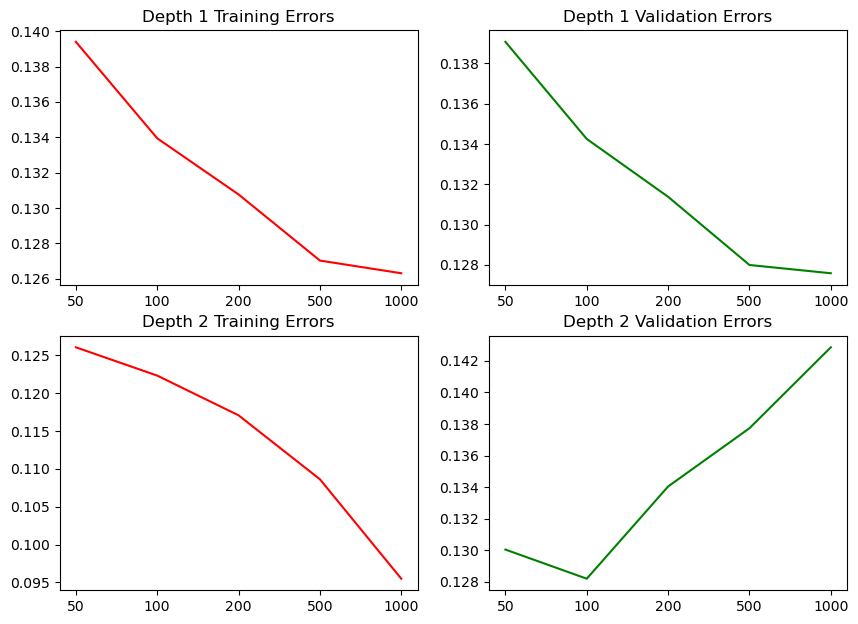

In [29]:
fig, ax = plt.subplots(2,2, figsize=(9,4))
plt.subplots_adjust(bottom=0.1, right=1, top=1.5)
esti_num[:0] = [0] # adjust for plot

for i in range(0,2):
    ax[i,0].plot(te_e[i], color='red')
    ax[i,0].title.set_text(f"Depth {i+1} Training Errors")
    ax[i,0].set_xticklabels(esti_num)

    ax[i,1].plot(v_e[i], color='green')
    ax[i,1].title.set_text(f"Depth {i+1} Validation Errors")
    ax[i,1].set_xticklabels(esti_num)

In [ ]:
# it seems depth 1 with 1000 estimator got the best performance
# now change learning rate
# adaboost 5
lr = [2.0, 1.0, 0.1, 0.01, 0.001]

t_e2 = []
v_e2 = []

for r in lr:
    dt_5 = tree.DecisionTreeClassifier(criterion='entropy',
                                       max_depth=1,
                                       random_state=seed)

    ada_5 = sklearn.ensemble.AdaBoostClassifier(estimator=dt_5,
                                                n_estimators=1000,
                                                learning_rate=r,
                                                random_state=seed)
    ada_5.fit(X_tr_unscaled, y_tr)

    t_e2.append(1 - ada_5.score(X_tr_unscaled, y_tr))
    v_e2.append(1 - ada_5.score(X_te_unscaled, y_te))

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(6,4))
plt.subplots_adjust(bottom=0.1, right=1, top=1.5)
lr[:0] = [0] # adjust for plot


ax[0].plot(t_e2, color='red')
ax[0].title.set_text("Training Errors")
ax[0].set_xticklabels(lr)

ax[1].plot(v_e2, color='green')
ax[1].title.set_text("Validation Errors")
ax[1].set_xticklabels(lr)

In [ ]:
# It seems that learing rate of 1.0 has the best performance overall.
# The best model for adaboost is the model with decision stump, number of estimator=1000, and learning rate=1.0
print(f'test error : {te_e[0][4]}')
print(f'validation error : {v_e[0][4]}')

In [21]:
learners = [('svm', svm.SVC(kernel='rbf', C=1)),
            ('knn35', KNeighborsClassifier(n_neighbors=35)),
            ('knn42', KNeighborsClassifier(n_neighbors=42)),
            ('nc', NearestCentroid()),
            ('lreg', LogisticRegression()),
            ('dec', tree.DecisionTreeClassifier(criterion='entropy', max_depth=100, random_state=seed))
           ]




stack = StackingClassifier(estimators=learners, final_estimator=LogisticRegression())

stack.fit(X_tr, y_tr)



StackingClassifier(estimators=[('svm', SVC(C=1)),
                               ('knn35', KNeighborsClassifier(n_neighbors=35)),
                               ('knn42', KNeighborsClassifier(n_neighbors=42)),
                               ('nc', NearestCentroid()),
                               ('lreg', LogisticRegression()),
                               ('dec',
                                DecisionTreeClassifier(criterion='entropy',
                                                       max_depth=100,
                                                       random_state=1234))],
                   final_estimator=LogisticRegression())

In [22]:
stackacc = 1 - accuracy_score(y_te, stack.predict(X_te))
print(stackacc)

0.14982578397212543


___
## Testing
Performance validation. You should practice good form and use validation or cross-validation to assess your models’ performance, do model selection, combine models, etc. You should not simply try a few variations and assume you are done.

Adaptation to under- and over-fitting. Machine learning is not very “one size fits all”; it is impossible to know for sure what model to choose, what features to give it, or how to set the parameters until you see how it does on the data. Therefore, much of machine learning revolves around assessing performance (e.g., is my poor performance due to underfitting, or overfitting?) and deciding how to modify your techniques in response. Your report should describe how, during your process, you decided how to adapt your models and why.

References:

https://www.kdnuggets.com/2021/05/deal-with-categorical-data-machine-learning.html

https://www.youtube.com/watch?v=8A7L0GsBiLQ

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html

https://www.geeksforgeeks.org/how-to-pretty-print-an-entire-pandas-series-or-dataframe/

